## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

pd.options.display.max_rows = None
pd.options.display.max_columns = None
sns.set()
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Import Dataset

In [2]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx")


In [3]:
df.shape

(414, 8)

In [4]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


#### Rename the column names. Makes it easy for me to use and more representative

In [5]:
df = df.rename(columns={"X1 transaction date":"transaction_date", "X2 house age":"house_age",
                  "X3 distance to the nearest MRT station":"distance_to_nearest_MRT", 
                  "X4 number of convenience stores":"number_of_convenience_stores",
                  "X5 latitude":"latitude", "X6 longitude":"longitude", 
                   "Y house price of unit area":"house_price"})

#### Check if the dataset has missing values

In [6]:
df.isnull().sum()

No                              0
transaction_date                0
house_age                       0
distance_to_nearest_MRT         0
number_of_convenience_stores    0
latitude                        0
longitude                       0
house_price                     0
dtype: int64

#### Get a high level overview of datatypes for each feature plus distribution

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   No                            414 non-null    int64  
 1   transaction_date              414 non-null    float64
 2   house_age                     414 non-null    float64
 3   distance_to_nearest_MRT       414 non-null    float64
 4   number_of_convenience_stores  414 non-null    int64  
 5   latitude                      414 non-null    float64
 6   longitude                     414 non-null    float64
 7   house_price                   414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [8]:
df.describe()

,No,transaction_date,house_age,distance_to_nearest_MRT,number_of_convenience_stores,latitude,longitude,house_price
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


#### Create a variable called year, clean up the transaction_date and also see the distribution
1. Based on information from the UCI website, dates such as 2013.250 represents 2013 March, 2013.500 represents 2013 June, etc. So, I had to clean the transaction_date column abit.


In [9]:
df["transaction_year"] = df["transaction_date"].astype(str).apply(lambda x: x.split(".")).str[0]
df["transaction_month"] = df["transaction_date"].astype(str).apply(lambda x: x.split(".")).str[1].str[0].\
                                            astype(int).replace({0:"jan", 1:"feb", 2:"mar", 3:"apr", 4:"may",
                                            5:"jun", 6:"jul", 7:"aug", 8:"sep", 9:"oct", 
                                            10:"nov", 11:"dec"})

df["transaction_date"] = df["transaction_year"] + "_" + df["transaction_month"]
df = df.drop("transaction_month", axis = 1)

In [10]:
df.head()


,No,transaction_date,house_age,distance_to_nearest_MRT,number_of_convenience_stores,latitude,longitude,house_price,transaction_year
0,1,2012_oct,32.0,84.87882,10,24.98298,121.54024,37.9,2012
1,2,2012_oct,19.5,306.59470,9,24.98034,121.53951,42.2,2012
2,3,2013_jun,13.3,561.98450,5,24.98746,121.54391,47.3,2013
3,4,2013_jun,13.3,561.98450,5,24.98746,121.54391,54.8,2013
4,5,2012_sep,5.0,390.56840,5,24.97937,121.54245,43.1,2012


#### Using the function below for plotting feature distributions in plotly

In [11]:
def plot_data(feature, title):
    return feature.iplot(kind='hist',bins=30,xTitle=title,linecolor='black', 
                             yTitle='count', title='histogram of ' + str(title))
    

#### Loop below helps us get a graphical picture of what the variables look like

In [12]:
for column in df.columns:
    plot_data(df[column], column)

#### To understand relationship between the independent features and target variable, I'll be grouping independent variables into bins and carrying out some analysis. 

In [13]:
df.head()

,No,transaction_date,house_age,distance_to_nearest_MRT,number_of_convenience_stores,latitude,longitude,house_price,transaction_year
0,1,2012_oct,32.0,84.87882,10,24.98298,121.54024,37.9,2012
1,2,2012_oct,19.5,306.59470,9,24.98034,121.53951,42.2,2012
2,3,2013_jun,13.3,561.98450,5,24.98746,121.54391,47.3,2013
3,4,2013_jun,13.3,561.98450,5,24.98746,121.54391,54.8,2013
4,5,2012_sep,5.0,390.56840,5,24.97937,121.54245,43.1,2012


In [14]:
df["decile_house_age"] = pd.qcut(df["house_age"], q = 10, labels = [1,2,3,4,5,6,7,8,9,10])
df["decile_distance_to_nearest_MRT_station"] = pd.qcut(df["distance_to_nearest_MRT"], q = 10, labels = [1,2,3,4,5,6,7,8,9,10])
df["quintile_number_convenience_stores"] = pd.qcut(df["number_of_convenience_stores"], q = 5, labels = [1,2,3,4,5])
df["decile_latitude"] = pd.qcut(df["latitude"], q = 10, labels = [1,2,3,4,5,6,7,8,9,10])
df["decile_longitude"] = pd.qcut(df["longitude"], q = 10, labels = [1,2,3,4,5,6,7,8,9,10])

#### The function below to check distribution across bins. Wrote it to avoid code repitition

In [15]:
def check_average_distribution(data, feature):
    return data.groupby(feature)["house_price"].mean()

####  year and house price

In [16]:
check_average_distribution(df, "transaction_year")

transaction_year
2012    36.304762
2013    38.713194
Name: house_price, dtype: float64

#### latitude and house_price

In [17]:
check_average_distribution(df, "decile_latitude")

decile_latitude
1     18.550000
2     32.016667
3     26.282500
4     40.639130
5     40.812821
6     38.133333
7     49.346512
8     45.748780
9     46.675000
10    41.328571
Name: house_price, dtype: float64

#### longitude and house_price

In [18]:
check_average_distribution(df, "decile_longitude")

decile_longitude
1     19.664444
2     27.192105
3     35.114634
4     38.790476
5     43.514286
6     42.890244
7     47.182927
8     50.097674
9     46.585000
10    29.231707
Name: house_price, dtype: float64

#### house_age and house_price

In [19]:
check_average_distribution(df, "decile_house_age")

decile_house_age
1     49.104651
2     46.221951
3     43.172500
4     35.327660
5     31.802703
6     33.400000
7     32.054762
8     31.402439
9     33.715000
10    42.890476
Name: house_price, dtype: float64

In [20]:
# pd.qcut(df["house_age"], 10).value_counts().sort_index()

#### distance_to_nearest_MRT_station and house_price

In [21]:
check_average_distribution(df, "decile_distance_to_nearest_MRT_station")

decile_distance_to_nearest_MRT_station
1     51.218605
2     46.790000
3     51.628571
4     43.868293
5     38.059091
6     41.374359
7     32.219512
8     27.807143
9     26.540000
10    20.097619
Name: house_price, dtype: float64

#### number_convenience_stores and house_price

In [22]:
check_average_distribution(df, "quintile_number_convenience_stores")

quintile_number_convenience_stores
1    28.651327
2    30.180000
3    42.434694
4    45.536765
5    47.976923
Name: house_price, dtype: float64

#### pairplot to identify possible other outliers

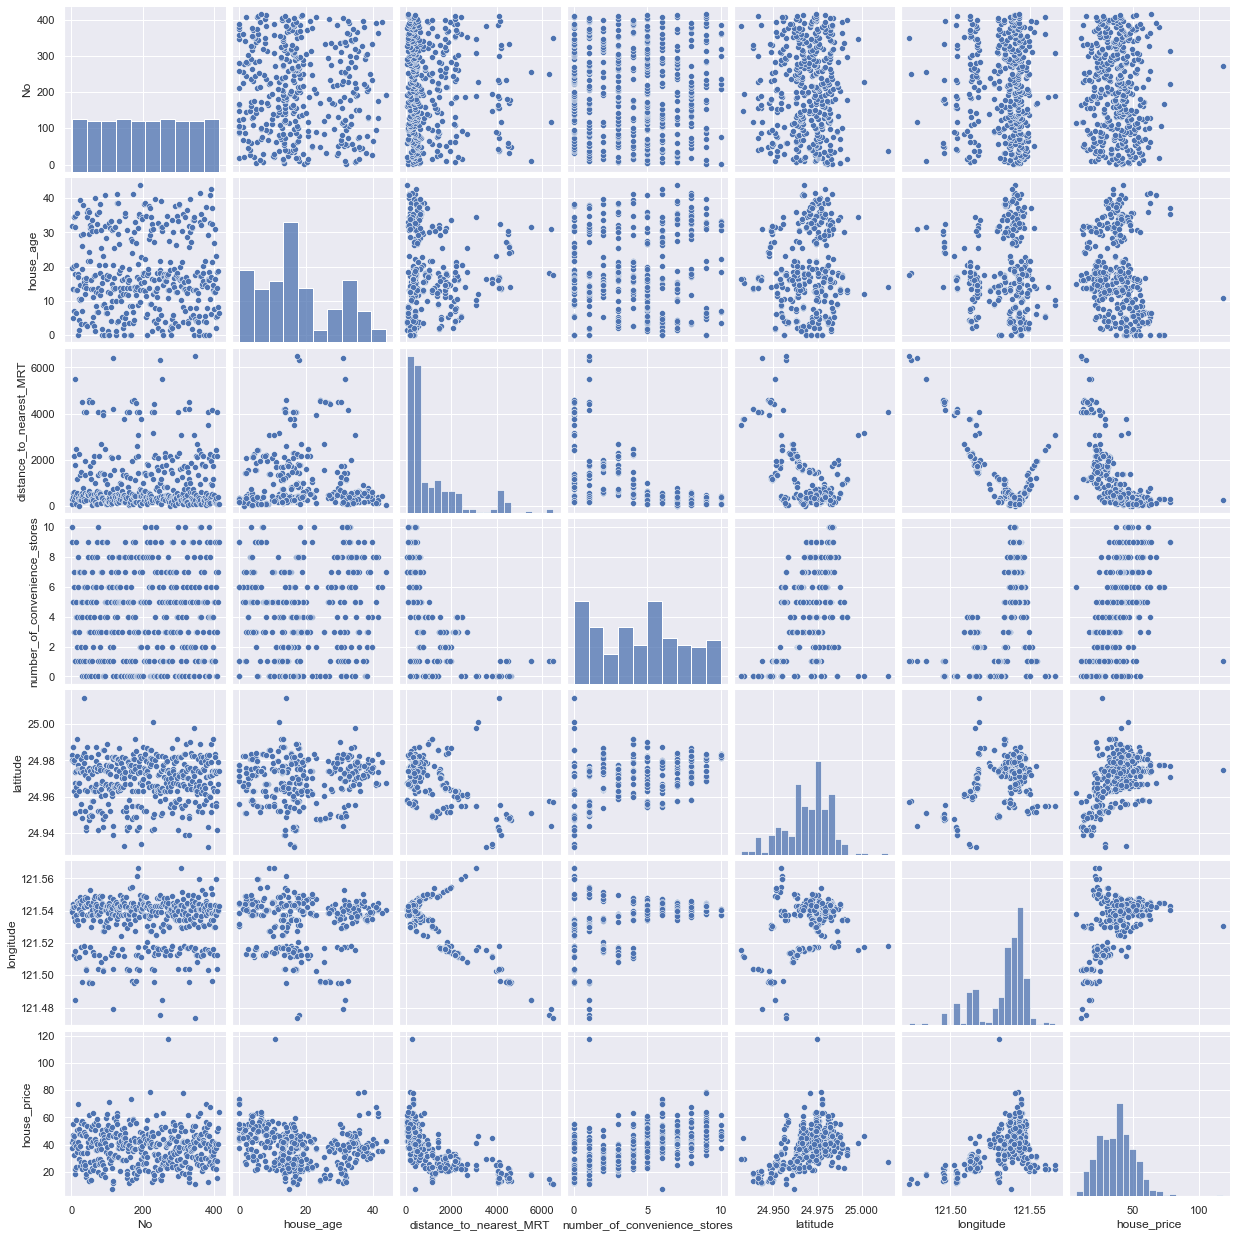

In [23]:
sns.pairplot(df)
plt.show()

1. houses with very high prices could be outliers. So, I'll be removing data points with house_price >= 117.5 from the dataset 

In [24]:
df = df[df["house_price"] < 117.5].reset_index().drop(["index"], axis=1)

#### correlation plot

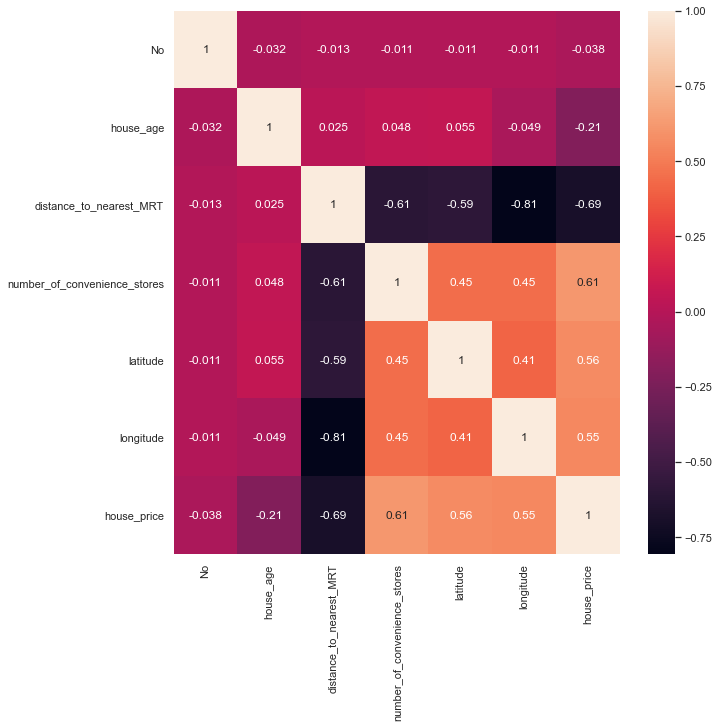

In [25]:
corr_df = df.corr()
fig,ax = plt.subplots(figsize = (10,10))
sns.heatmap(corr_df , annot = True , annot_kws = {'size':12})
plt.show()

#### Some insights from the EDA
1. The house_age variable has values between 0 to ~44 years with three different peaks. The highest peak is for houses that are between 13 to 19 years old.
2. The majority of the houses (approximately 67%) are located 0 to 1000 meters (i.e., 1km) away from the nearest MRT (Mass Rapid Transit) station. 
3. I noticed that approximately 69% of transactions happened in 2013 - the majority occurred in January, May, and June 2013. 
4. The most occurring number of convenience stores is 5 and 0. Approximately 16% (i.e., 67/413) of houses don't have convenience stores around in the UCI real estate valuation dataset. Most likely, these houses aren't located in highly residential areas. 
5. I discovered that more expensive houses have a higher number of convenience stores than less costly houses (The average house price for real estate with at least a single convenience store is about 66% higher than houses without any convenience store around).
6. I also noticed that the average house prices tend to decrease as the distance between a house and the nearest MRT station increases. In essence, houses closer to MRT stations are relatively more expensive than houses farther from an MRT station.
7. More than 50% of the houses have anything between 1 and 6 convenience stores.
8. Over 69% of the houses are clustered around latitude [24.96o,24.98499o] and longitude [121.53o,121.55o].
9. The mean and median house price is 37.98 and 38.34 Ping respectively. Also, over 80% of the houses cost around most houses cost around 20 to 54.59 Ping. 
10. I saw a single house that cost 117.5 Ping. This is an outlier, and I had to remove the data points from the dataset where house price >= 117.5 
11. The target_variable is a bit skewed, and on average, house prices were relatively higher in 2013 than in 2012. Perhaps, could be linked to a situation that occurred around 2013
12. As the age of a house increases, the average house price is likely to decrease. However, this doesn't hold for houses above 35 years old because the average price increased from 33 to 42 from the 9th to 10th decile. 
13. I observed the following correlation between between target variable (house price) and independent variables: distance_to_nearest_MRT_station(-0.69), number_of_convenience_stores (0.61), latitude (0.56), longitude (0.55), house_age (-0.21) and transaction_date(0.082)



## Modelling
1. For this project, I'll only build a baseline model. I outlined a couple other things that can be done to possibly improve the model or project at the end of this notebook (i.e. If I were to dedicate more time to the project)

In [26]:
df.head()

,No,transaction_date,house_age,distance_to_nearest_MRT,number_of_convenience_stores,latitude,longitude,house_price,transaction_year,decile_house_age,decile_distance_to_nearest_MRT_station,quintile_number_convenience_stores,decile_latitude,decile_longitude
0,1,2012_oct,32.0,84.87882,10,24.98298,121.54024,37.9,2012,9,1,5,10,6
1,2,2012_oct,19.5,306.59470,9,24.98034,121.53951,42.2,2012,7,3,5,9,6
2,3,2013_jun,13.3,561.98450,5,24.98746,121.54391,47.3,2013,4,6,3,10,8
3,4,2013_jun,13.3,561.98450,5,24.98746,121.54391,54.8,2013,4,6,3,10,8
4,5,2012_sep,5.0,390.56840,5,24.97937,121.54245,43.1,2012,2,4,3,8,7


#### Remove variables I used only for analysis and separate data in independent and dependent features.

1. These variables won't be useful in the model, as I only used them for EDA

In [27]:
df = df.set_index('No')
X = df.drop(['house_price', 'transaction_year', 'decile_house_age', 
            'decile_distance_to_nearest_MRT_station',
            'quintile_number_convenience_stores', 'decile_latitude', 'decile_longitude', 
             "transaction_date"], axis = 1)

y = df["house_price"]

#### split data in train_set and test_set

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 22)

In [29]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(289, 5) (124, 5) (289,) (124,)


#### build a baseline Random Forest Model

In [30]:
## Create a Random Forest Regressor object 
regressor = RandomForestRegressor()

## fit the object on the train set
regressor.fit(X_train, y_train)

print('Random Forest Parameters:\n')
pprint(regressor.get_params())

Random Forest Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


#### run the model on test set to generate predictions

In [31]:
y_pred = regressor.predict(X_test)

### overview of actual and predicted

In [32]:
actual_predicted_df = pd.concat([pd.DataFrame(y_test).reset_index().drop("No", axis = 1), pd.DataFrame(y_pred)], axis=1).\
                            rename(columns={"house_price":"actual_house_price", 0:"predicted_house_price"})
actual_predicted_df.head()

,actual_house_price,predicted_house_price
0,42.0,41.228000
1,28.9,26.288417
2,15.9,15.622762
3,20.7,16.422000
4,19.0,16.657000


#### the function below uses cross-validation for model evaluation on the train set

In [33]:
# Define a function for model evaluation using cross validation
def evaluate_model_cross_validation(name, model, X_train, y_train, folds = 10):
 
    # MAE (Mean Absolute Error)
    metric='neg_mean_absolute_error'
    scores = cross_val_score(regressor, X_train, y_train, scoring=metric, cv=folds, n_jobs=-1)
    mean_score, std_score = np.mean(scores), np.std(scores)
    print('>%s - train set - MAE: %.3f (+/-%.3f)' % (name, mean_score, std_score))
    
    
    # MSE (Mean Squared Error)
    metric='neg_mean_squared_error'
    scores = cross_val_score(regressor, X_train, y_train, scoring=metric, cv=folds, n_jobs=-1)
    mean_score, std_score = np.mean(scores), np.std(scores)
    print('>%s - train set - MSE: %.3f (+/-%.3f)' % (name, mean_score, std_score))
    
    # R^2 (R-Squared)
    metric='r2'
    scores = cross_val_score(regressor, X_train, y_train, scoring=metric, cv=folds, n_jobs=-1)
    mean_score, std_score = np.mean(scores), np.std(scores)
    print('>%s - train set - R^2: %.3f (+/-%.3f)' % (name, mean_score, std_score))

##### The function below is for model evaluation on the test set


In [34]:
def evaluate_model_on_test_set(name, model, y_test, y_predicted):
    print('>%s - test set - MAE: %.3f' % (name, mean_absolute_error(y_test, y_predicted)))
    print('>%s - test set - MSE: %.3f' % (name, mean_squared_error(y_test, y_predicted)))
    print('>%s - test set - R^2: %.3f' % (name, r2_score(y_test, y_predicted)))

#### Evaluate the performance of the baseline model on train set

In [35]:
evaluate_model_cross_validation("RF_baseline_model", regressor, X_train, y_train, 10)

>RF_baseline_model - train set - MAE: -4.732 (+/-1.217)
>RF_baseline_model - train set - MSE: -43.396 (+/-26.033)
>RF_baseline_model - train set - R^2: 0.733 (+/-0.137)


#### Evaluate the performance of the baseline model on test set

In [36]:
evaluate_model_on_test_set("RF_baseline_model", regressor, y_test, y_pred)

>RF_baseline_model - test set - MAE: 4.890
>RF_baseline_model - test set - MSE: 47.709
>RF_baseline_model - test set - R^2: 0.722


## Additional things I'd have done if I was to dedicate more time to this project
1. Hyper-parameter tuning using Gridsearch CV - to get the best set of parameters that increase the performance of the Random Forest Regressor
2. Train other regressors: Xgboost, SVM, Linear e.t.c and see if they perform better than Random Forest Regressor
3. Carry out some geo-location analysis to see if I could do more with the latitude and longitude

P.S: This project took me about 2 hours to complete
    